In [4]:
import os
# print(os.listdir("C://Users//navin//Dropbox//Ryerson University//CIND 820//complaints"))

import pandas as pd
import numpy as np
import zipfile
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
#import warnings

In [5]:
df = pd.read_csv('complaints.csv')
#The dataset can be found on 
#https://catalog.data.gov/dataset/consumer-complaint-database
#our dataset is download on Sept 17, 2020
df.shape

(1757764, 18)

In [6]:
dfNew = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
dfNew = dfNew[pd.notnull(dfNew['Consumer complaint narrative'])]
dfNew = dfNew[pd.notnull(dfNew['Product'])]
# Renaming second column for a simpler name
dfNew.columns = ['Product', 'Consumer_complaint'] 

dfNew.shape

(596333, 2)

In [7]:
dfNew.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other reports', 
              'Credit reporting': 'Credit reporting, repair, or other reports',
              'Credit card': 'Credit card or prepaid card',
              'Prepaid card': 'Credit card or prepaid card',
              'Payday loan': 'Payday loan, title loan, or personal loan',
              'Money transfers': 'Money transfer, virtual currency, or money service',
              'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [8]:
dfNew.head(5)

,Product,Consumer_complaint
0,"Credit reporting, repair, or other reports",Although I am checking for and addressing miss...
1,Debt collection,transworld systems inc. \nis trying to collect...
3,Debt collection,"Over the past 2 weeks, I have been receiving e..."
5,Debt collection,Quickclickloans.com hired an attorney XXXX XXX...
6,"Credit reporting, repair, or other reports","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/..."


In [11]:
dfNewOriginal=dfNew.copy()
#dfNew=dfNew[:1000]


In [12]:
#Random Sampling
dfNew=dfNew.sample(n=20000, random_state=6)
dfNew.head(5)
#dfNew.to_csv ('complaints_samples.csv', index = False, header=True)

,Product,Consumer_complaint
189897,Debt collection,Family and friends were contacted multiple tim...
843992,"Credit reporting, repair, or other reports",The account below is paid off. \nXXXX XXXX Las...
96403,Credit card or prepaid card,"Hello, I've had my Capital One Venture account..."
1716414,Student loan,"On XX/XX/2018 and XX/XX/2018, two friends of m..."
248374,Checking or savings account,On Thursday XX/XX/2020 around XXXX XXXX I logg...


PreProcessing

Lowercase

Remove Punctuation

Remove Stop words

Romove Digits

Limmatization


In [13]:
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x: ' '.join([i.lower() for i in x.split()]))

In [14]:
import string
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x:' '.join([char for char in x.split() if char not in string.punctuation]))
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].str.replace(r'[^\w\s]'," ")
dfNew['Consumer_complaint'] = dfNew['Consumer_complaint'].str.replace(r"xx+\s"," ")
dfNew['Consumer_complaint'] = dfNew['Consumer_complaint'].str.replace(r"xx+[a-z]+\s"," ")
dfNew['Consumer_complaint'] = dfNew['Consumer_complaint'].str.replace(r"[a-z]+xx+\s"," ")
dfNew['Consumer_complaint'] = dfNew['Consumer_complaint'].str.replace(r"xxxx"," ")

dfNew['Consumer_complaint'].head(5)

189897     family and friends were contacted multiple tim...
843992     the account below is paid off    last reported...
96403      hello  i ve had my capital one venture account...
1716414    on   2018 and   2018  two friends of mine rece...
248374     on thursday   2020 around   i logged into my a...
Name: Consumer_complaint, dtype: object

In [15]:
#pip install nltk
from nltk.corpus import stopwords
stopE = stopwords.words('english')
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x: ' '.join([char for char in x.split() if char not in stopE]))

In [16]:
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x: ' '.join([char for char in x.split() if not char.isdigit()]))

dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x: ' '.join([char for char in x.split() if char.isalpha()]))

In [18]:
# pip install pattern
# Run this part twice
import pattern

from pattern.en import lemma
dfNew['Consumer_complaint'] =dfNew['Consumer_complaint'].apply(lambda x:' '.join([lemma(wd) for wd in x.split()]))


In [14]:
import pattern

In [19]:
dfNew.Consumer_complaint.head(10)

189897     family friend contact multiple time woman name...
843992     account paid last report good overview paid or...
96403      hello capital one venture account since longer...
1716414    two friend mine receive call navient company c...
248374     thursday around log account discover negative ...
393634     receive call citibank n ask receive check sett...
256330     review credit report find negative account ent...
1407076    dispute continuosly equifax blatant refusal re...
1178913    purchase money order amount fifth third bank i...
1714522    student loan open question put forbearance sel...
Name: Consumer_complaint, dtype: object

CROSS VALIDATION STRATIFIED KFOLD

In [20]:
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report
X=dfNew.Consumer_complaint
y=dfNew['Product']
labels_l=['Bank account or service', 'Checking or savings account','Consumer Loan','Credit card or prepaid card',
          'Credit reporting, repair, or other reports','Debt collection',
          'Money transfer, virtual currency, or money service' ,'Mortgage','Other financial service',
          'Payday loan, title loan, or personal loan','Student loan','Vehicle loan or lease']

metricsNB = []
metricsSVM = []
metricsLR = []
metricsRF = []

conf_matrix_list_of_arrays_LR=[]
conf_matrix_list_of_arrays_SVM=[]
conf_matrix_list_of_arrays_NB=[]
conf_matrix_list_of_arrays_RF=[]

SVM_report = pd.DataFrame(columns=['precision' , 'recall' ,'f1-score' , 'support'])
NB_report = pd.DataFrame(columns=['precision' , 'recall' ,'f1-score' , 'support'])
LR_report = pd.DataFrame(columns=['precision' , 'recall' ,'f1-score' , 'support'])
RF_report = pd.DataFrame(columns=['precision' , 'recall' ,'f1-score' , 'support'])


X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=1)
skf = StratifiedKFold(n_splits=10)
for train_index, test_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    #vect = CountVectorizer(ngram_range=(1,2), max_features=1000 , stop_words="English")
    vect=CountVectorizer(max_features=10000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    
    NB_Final=MultinomialNB(alpha=1, class_prior=None, fit_prior='True')
    NB_Final.fit(X_train_dtm, y_train)
    y_pred_class_NB = NB_Final.predict(X_test_dtm)
    metricsNB.append( accuracy_score(y_test, y_pred_class_NB))
    NB_report_tmp=pd.DataFrame(classification_report(y_test,y_pred_class_NB, output_dict=True)).transpose()
    NB_report=NB_report.append(NB_report_tmp)
    conf_matrix_list_of_arrays_NB.append( confusion_matrix(y_test, y_pred_class_NB, labels=labels_l))
    
    
    SVM_Final=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=820,
          multi_class='crammer_singer', penalty='l2', random_state=None,
          tol=0.0001, verbose=0)
    SVM_Final.fit(X_train_dtm, y_train)
    y_pred_class_SVM = SVM_Final.predict(X_test_dtm)
    metricsSVM.append(accuracy_score(y_test, y_pred_class_SVM))
    SVM_report_tmp=pd.DataFrame(classification_report(y_test,y_pred_class_SVM, output_dict=True)).transpose()
    SVM_report=SVM_report.append(SVM_report_tmp)
    conf_matrix_list_of_arrays_SVM.append( confusion_matrix(y_test, y_pred_class_SVM, labels=labels_l))
    
    
    LR_Final=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=30,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
    LR_Final.fit(X_train_dtm, y_train)
    y_pred_class_LR = LR_Final.predict(X_test_dtm)
    metricsLR.append(accuracy_score(y_test, y_pred_class_LR))
    LR_report_tmp=pd.DataFrame(classification_report(y_test,y_pred_class_LR, output_dict=True)).transpose()
    LR_report=LR_report.append(LR_report_tmp)
    conf_matrix_list_of_arrays_LR.append( confusion_matrix(y_test, y_pred_class_LR, labels=labels_l))
    
    RF_Final=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=99, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=346,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
    RF_Final.fit(X_train_dtm, y_train)
    y_pred_class_RF = RF_Final.predict(X_test_dtm)
    metricsRF.append(accuracy_score(y_test, y_pred_class_RF))
    RF_report_tmp=pd.DataFrame(classification_report(y_test,y_pred_class_RF, output_dict=True)).transpose()
    RF_report=RF_report.append(RF_report_tmp)
    conf_matrix_list_of_arrays_RF.append( confusion_matrix(y_test, y_pred_class_RF, labels=labels_l))
    
metricsNB = np.array(metricsNB)
metricsSVM = np.array(metricsSVM)
metricsLR = np.array(metricsLR)
metricsRF = np.array(metricsRF)

conf_mx_LR=sum(conf_matrix_list_of_arrays_LR)
conf_mx_NB=sum(conf_matrix_list_of_arrays_NB)
conf_mx_SVM=sum(conf_matrix_list_of_arrays_SVM)
conf_mx_RF=sum(conf_matrix_list_of_arrays_RF)


print('Mean accuracy NB: ', np.mean(metricsNB, axis=0))
print('Mean accuracy SVM: ', np.mean(metricsSVM, axis=0))
print('Mean accuracy LR: ', np.mean(metricsLR, axis=0))
print('Mean accuracy RF: ', np.mean(metricsRF, axis=0))


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Mean accuracy NB:  0.76405
Mean accuracy SVM:  0.70575
Mean accuracy LR:  0.7606999999999999
Mean accuracy RF:  0.7598


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
import numbers
SVM_report['name']=SVM_report.index
SVM_report1=SVM_report.transpose()
SVM_report1.drop(SVM_report1.tail(1).index,inplace=True)
MeanSVM_Report = SVM_report1.groupby(by=SVM_report1.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
MeanSVM_Report.transpose()

,precision,recall,f1-score,support
Bank account or service,0.275936,0.292000,0.282938,50.00000
Checking or savings account,0.440548,0.443071,0.440907,80.60000
Consumer Loan,0.216508,0.249811,0.228839,32.90000
Credit card or prepaid card,0.649889,0.622378,0.635455,212.10000
"Credit reporting, repair, or other reports",0.809930,0.835394,0.822334,792.80000
Debt collection,0.700520,0.680746,0.690341,407.20000
"Money transfer, virtual currency, or money service",0.586220,0.556534,0.569368,42.40000
Mortgage,0.825344,0.786117,0.805015,223.50000
Other financial service,0.100000,0.050000,0.066667,1.60000
"Payday loan, title loan, or personal loan",0.268803,0.268750,0.267350,32.00000


In [22]:
NB_report['name']=NB_report.index
NB_report1=NB_report.transpose()
NB_report1.drop(NB_report1.tail(1).index,inplace=True)
MeanNB_Report = NB_report1.groupby(by=NB_report1.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
MeanNB_Report.transpose()

,precision,recall,f1-score,support
Bank account or service,0.359560,0.220000,0.271976,50.00000
Checking or savings account,0.499952,0.652546,0.565407,80.60000
Consumer Loan,0.306820,0.170644,0.214270,32.90000
Credit card or prepaid card,0.695414,0.782157,0.736105,212.10000
"Credit reporting, repair, or other reports",0.863050,0.822151,0.842007,792.80000
Debt collection,0.784699,0.730105,0.756299,407.20000
"Money transfer, virtual currency, or money service",0.722964,0.696069,0.707111,42.40000
Mortgage,0.863003,0.910524,0.885894,223.50000
Other financial service,0.000000,0.000000,0.000000,1.60000
"Payday loan, title loan, or personal loan",0.439068,0.368750,0.397302,32.00000


In [23]:
LR_report['name']=LR_report.index
LR_report1=LR_report.transpose()
LR_report1.drop(LR_report1.tail(1).index,inplace=True)
MeanLR_Report = LR_report1.groupby(by=LR_report1.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
MeanLR_Report.transpose()

,precision,recall,f1-score,support
Bank account or service,0.347084,0.240000,0.282720,50.0000
Checking or savings account,0.499984,0.498735,0.498838,80.6000
Consumer Loan,0.290053,0.140057,0.181509,32.9000
Credit card or prepaid card,0.715541,0.720405,0.717276,212.1000
"Credit reporting, repair, or other reports",0.820217,0.878533,0.848244,792.8000
Debt collection,0.738341,0.761292,0.749451,407.2000
"Money transfer, virtual currency, or money service",0.703015,0.618162,0.655197,42.4000
Mortgage,0.869560,0.856364,0.862539,223.5000
Other financial service,0.000000,0.000000,0.000000,1.6000
"Payday loan, title loan, or personal loan",0.460323,0.271875,0.339699,32.0000


In [24]:
RF_report['name']=RF_report.index
RF_report1=RF_report.transpose()
RF_report1.drop(RF_report1.tail(1).index,inplace=True)
MeanRF_Report = RF_report1.groupby(by=RF_report1.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
MeanRF_Report.transpose()

,precision,recall,f1-score,support
Bank account or service,0.133333,0.006000,0.011466,50.0000
Checking or savings account,0.540154,0.498627,0.517277,80.6000
Consumer Loan,0.100000,0.003125,0.006061,32.9000
Credit card or prepaid card,0.696442,0.742085,0.717892,212.1000
"Credit reporting, repair, or other reports",0.780886,0.925833,0.847109,792.8000
Debt collection,0.753717,0.770626,0.761931,407.2000
"Money transfer, virtual currency, or money service",0.827382,0.311351,0.449805,42.4000
Mortgage,0.790497,0.882307,0.833690,223.5000
Other financial service,0.000000,0.000000,0.000000,1.6000
"Payday loan, title loan, or personal loan",0.383333,0.015625,0.029778,32.0000


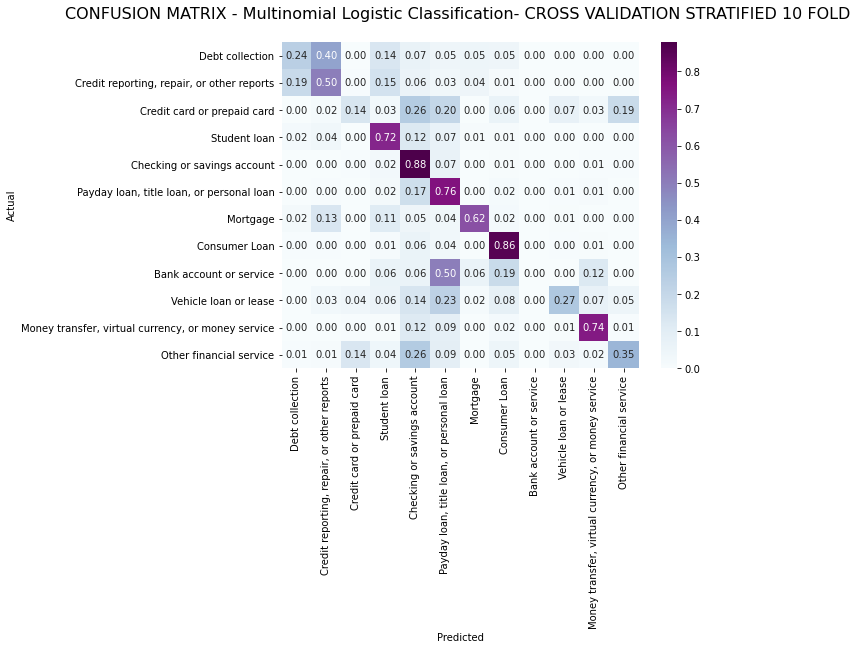

In [25]:

cmn = conf_mx_LR.astype('float') / conf_mx_LR.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn, annot=True, cmap="BuPu", fmt='.2f',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Multinomial Logistic Classification- CROSS VALIDATION STRATIFIED 10 FOLD \n", size=16);



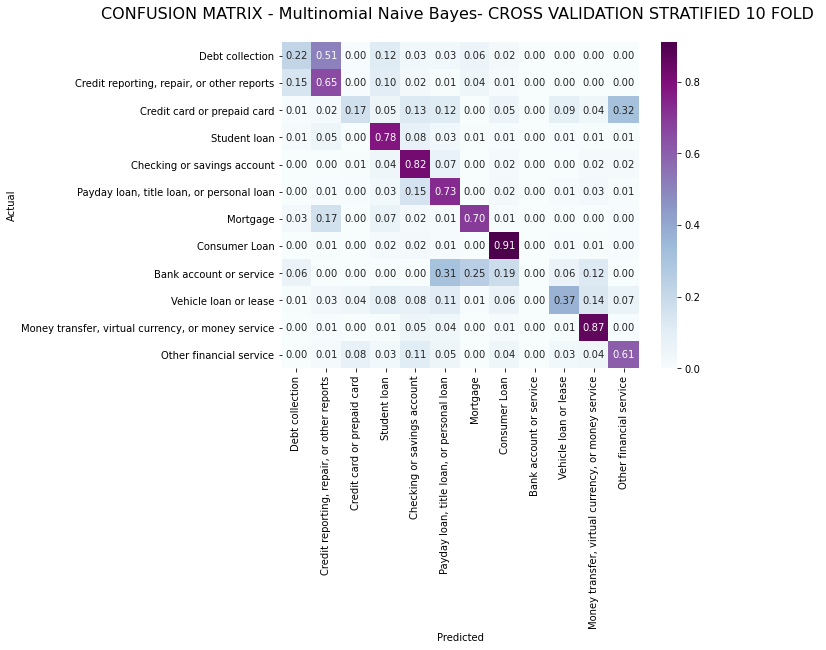

In [26]:

cmn = conf_mx_NB.astype('float') / conf_mx_NB.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn, annot=True, cmap="BuPu", fmt='.2f',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Multinomial Naive Bayes- CROSS VALIDATION STRATIFIED 10 FOLD \n", size=16);

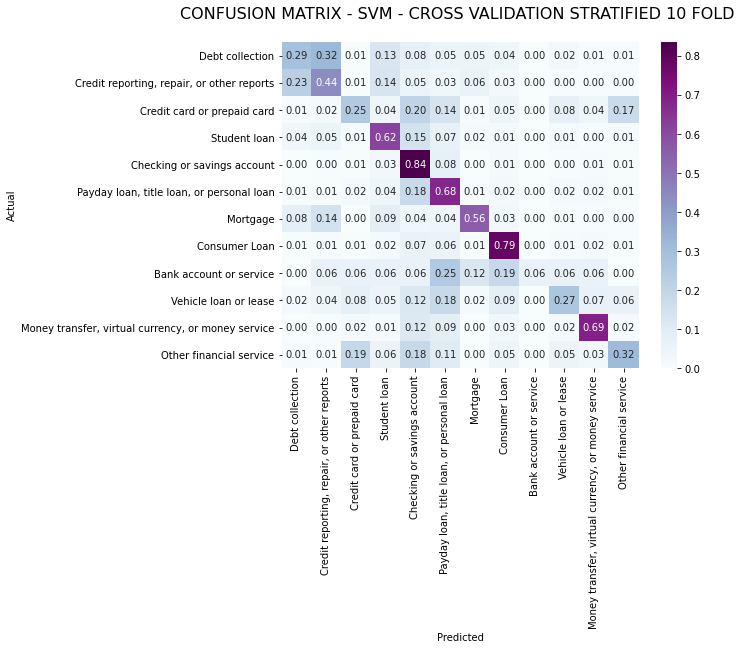

In [27]:

cmn = conf_mx_SVM.astype('float') / conf_mx_SVM.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn, annot=True, cmap="BuPu", fmt='.2f',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - SVM - CROSS VALIDATION STRATIFIED 10 FOLD \n", size=16);

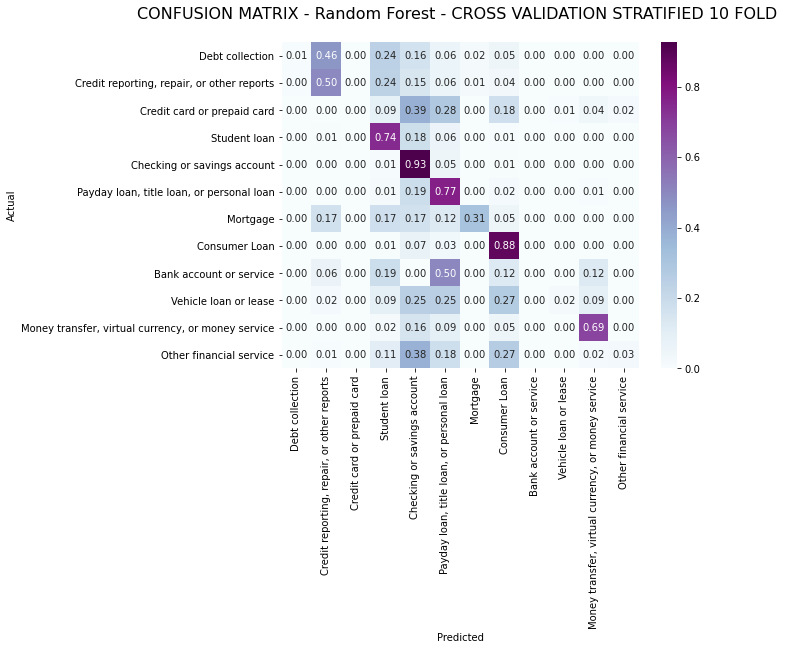

In [28]:

cmn = conf_mx_RF.astype('float') / conf_mx_RF.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn, annot=True, cmap="BuPu", fmt='.2f',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Random Forest - CROSS VALIDATION STRATIFIED 10 FOLD \n", size=16);

CROSS VALIDATION KFOLD

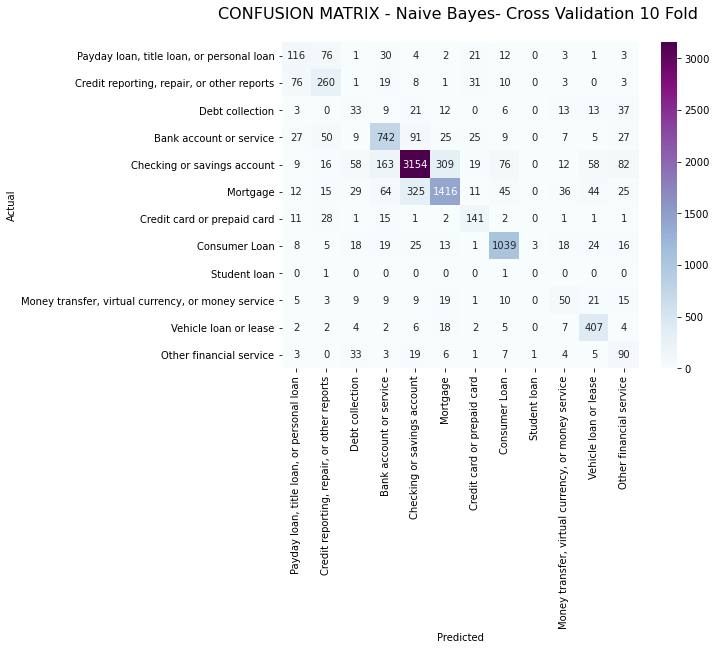

In [48]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_mc1, annot=True, cmap="BuPu", fmt='d',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Naive Bayes- Cross Validation 10 Fold \n", size=16);

In the method below I apply fit() on whole data and then apply transform() on train set and test set separately

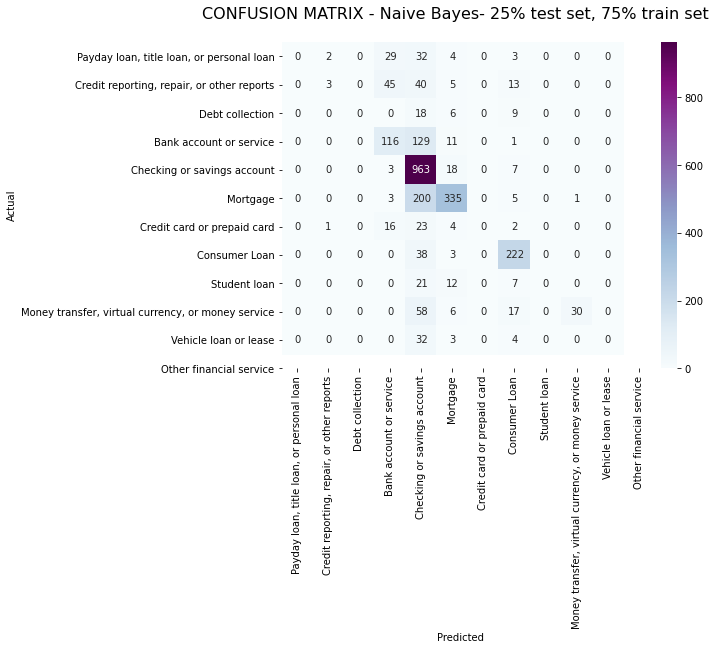

In [50]:
confusion_mc2=confusion_matrix(valid_y,y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_mc2, annot=True, cmap="BuPu", fmt='d',
            xticklabels=dfNew.Product.unique(), 
            yticklabels=dfNew.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Naive Bayes- 25% test set, 75% train set  \n", size=16);